# HW6 代码部分

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from collections import defaultdict
import copy

In [2]:
def translation(img, X, Y):
    '''
    平移变换代码，X，Y为竖直和水平方向平移的坐标
    '''
    height, width, channel = img.shape
    G_inv =np.eye(3)  # 初始化Gi为3*3的初始单位矩阵
    G_inv[0:2,2] = [X,Y] # 变换矩阵利用控制点在两张图上的位移得到
    newImg = img.copy()
    for x in range(height):
        for y in range(width): # 遍历每个点
            newImg[x,y]=255 #初始颜色设为白色
    for x in range(height):
        for y in range(width): # 遍历每个点
            Gi_X = np.dot(G_inv, np.array([x,y,1]))
            if Gi_X[0]<0 or Gi_X[1]<0 or Gi_X[0]>=height or Gi_X[1]>=width:#如果不在图像范围内就不继续
                continue
            newImg[int(Gi_X[0]),int(Gi_X[1])]=img[x,y]#取整
    return newImg

(<matplotlib.image.AxesImage at 0x223c66b1fd0>,
 Text(0.5, 1.0, 'after translation'))

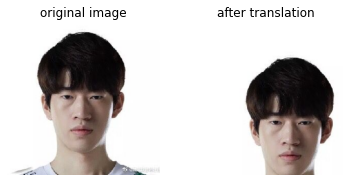

In [3]:
#平移变换的样例
source = cv2.imread("xiaohu.jpg")     # 人脸
source = cv2.cvtColor(source, cv2.COLOR_BGR2RGB) #cv2默认是BGR，我们转成RGB

newImg = translation(source,50,50 ) # 利用平移变换得到新图片

plt.subplot(1, 2, 1), plt.axis("off")
plt.imshow(source),plt.title('original image')
plt.subplot(1, 2, 2), plt.axis("off")
plt.imshow(newImg),plt.title('after translation')

In [4]:
def localAffine(target, U, target_U, epsilon):
    '''局部仿射函数，寻找X=T^{-1} (Y)的函数关系，返回一个对应的position map'''

    height, width, channel = target.shape
    position_map = defaultdict(lambda: np.zeros(3))  # 构造position_map映射字典，初始为0向量

    # 得到3*3变换矩阵
    G_inv = defaultdict(lambda: np.eye(3))  # 初始化Gi，字典内是3*3的初始单位矩阵
    num_control = len(U) # 控制点个数
    for each_point in range(num_control):#改变（1，3）和（2，3）位置的元素为位移量
        G_inv[each_point][0:2,2] = U[each_point] - target_U[each_point] # 变换矩阵利用控制点在两张图上的位移得到

    for x in range(height):
        for y in range(width): # 遍历每个个点
            Y = (x,y)
            distance = np.sqrt(((np.array(Y) - target_U) ** 2).sum(axis=1))  # Y到target图中每一个控制点的距离
            w = 1 / (distance ** epsilon) if distance.all() else np.ones(num_control)
            # 如果不是控制点正常更新w，否则先随便赋一个值，下面再统一更新控制点
            w = w / w.sum()
            for i in range(num_control):
                Gi_X = np.dot(G_inv[i], np.array([x,y,1]))
                position_map[Y] += w[i] * Gi_X    # 利用w对Gi加权
            position_map[Y] = position_map[Y][:2]     # 把向量最后的1去除

    for i in range(num_control):
        position_map[tuple(target_U[i])] = U[i] # 控制点Y的映射就是X
    return position_map


# 后向变换
def backwardTrans(source, target, position_map):
    height,width = target.shape[0],target.shape[1]

    # 对每个像素点标志是否已经填过
    is_paint = np.zeros((height,width),dtype='uint8')
    print(is_paint.shape)
    '''根据变换函数position_map完成反向图变换'''

    newImg = np.zeros_like(target)   # 变换后的target
    for i in range(height):
        for j in range(width): # 遍历target每一个像素点
            X = position_map[i, j] # source中对应的点（精确位置）
            u, v = X - X.astype(int)
            neigh_i, neigh_j = X.astype(int) # 得到附近像素点和垂直水平距离u,v
            # 进行插值，得到X位置的像素值，也就是newImg在Y处像素值
            if neigh_i < 0 or neigh_j < 0 or neigh_i+1 >source.shape[0]-1  or neigh_j+1 >source.shape[1]-1:
                is_paint[i,j]=1
                continue #如果这个点的位置出界了就不填
            newImg[i,j] = (1 - u) * (1 - v) * source[neigh_i, neigh_j] + (1 - u) * v * source[neigh_i,neigh_j + 1] +\
                    u * (1 - v) * source[neigh_i +1,neigh_j] +  u * v * source[neigh_i + 1,neigh_j + 1]

    
    # 对没有填的区域进行修复
    newImg = cv2.inpaint(newImg, is_paint, 13, cv2.INPAINT_NS)

    return newImg.astype(np.uint8)  # 变成像素需要的int


In [5]:
#找点坐标
img = cv2.imread("xiaohu.jpg")     # 人脸
img = cv2.imread('ape.png')
target_list=[]
img =cv2.resize(img, source.shape[:2])

def on_click(event, x, y,w,h):
    '''
    鼠标点击事件
    '''
    if event == cv2.EVENT_LBUTTONDOWN:
        xy = "%d,%d" % (y,x)
        target_list.append([y,x])#坐标转置后存在列表里
        cv2.circle(img, (x, y), 2, (0, 255, 255), thickness=-1)#标出来
        cv2.putText(img, xy, (x, y), cv2.FONT_HERSHEY_PLAIN,
                    1.0, (0, 0, 0), thickness=1)#print出具体的坐标
        print(y,x)
        cv2.imshow("image", img)


cv2.namedWindow("image")
cv2.setMouseCallback("image", on_click)
cv2.imshow("image", img)
cv2.waitKey(0)
print(target_list)

[]


(300, 300)
(300, 300)
(300, 300)


(<matplotlib.image.AxesImage at 0x223cd8ef7c0>, Text(0.5, 1.0, 'e = 2'))

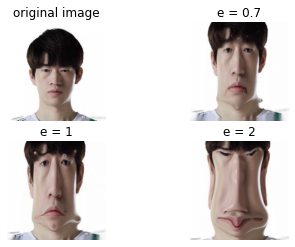

In [25]:
source = cv2.imread("xiaohu.jpg")     # 人脸
target = cv2.imread("ape.png")       # 大猩猩
target =cv2.resize(target, source.shape[:2])
U = np.array([[148, 108], [149, 130], [149, 164], [149, 185], [150, 149], [188, 130], 
                    [189, 166], [212, 126], [212, 146], [213, 165]]) # 人脸控制点

# U_target = np.array([[29, 59], [37, 110], [36, 147], [28, 193], [27, 128], [180, 80],
#                  [187, 164], [213, 61], [239, 97], [240, 158],[210,199]])# 猩猩控制点

U_target = np.array([[34, 84], [41, 125], [42, 173], [29, 206], [48, 147], [216, 102], 
                    [215, 176], [233, 86], [261, 142], [237, 217]])#参照物控制点
# epsilon = 1.2 # 衰减参数
#########################################################################################

source = cv2.cvtColor(source, cv2.COLOR_BGR2RGB) #cv2默认是BGR，我们转成RGB
target = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)

position_map = localAffine(target, U, U_target, 0.7)# 得到Y和X对应关系
newImg1 = backwardTrans(source, target, position_map) # 利用反向变换得到新图片

position_map = localAffine(target, U, U_target, 1)
newImg2 = backwardTrans(source, target, position_map)

position_map = localAffine(target, U, U_target, 2)
newImg3 = backwardTrans(source, target, position_map)

plt.subplot(2, 2, 1), plt.axis("off")
plt.imshow(source),plt.title('original image')
plt.subplot(2, 2, 2), plt.axis("off")
plt.imshow(newImg1),plt.title('e = 0.7')
plt.subplot(2, 2, 3), plt.axis("off")
plt.imshow(newImg2),plt.title('e = 1')
plt.subplot(2, 2, 4), plt.axis("off")
plt.imshow(newImg3),plt.title('e = 2')